In [48]:
#%matplotlib inline
%matplotlib qt5
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.patches import Patch
plt.rcParams['figure.figsize'] = [16, 8]
cmap = plt.cm.get_cmap('brg', 5)


import numpy as np
import scipy.stats
import scipy.optimize
import sklearn.decomposition
import sklearn.cluster
import time
import wfdb
from scipy.special import softmax

from collections import Counter
from functools import reduce

In [2]:
# https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
from matplotlib.patches import Ellipse
import matplotlib.transforms
def confidence_ellipse(mu, cov, dims, ax, n_std=3.0, facecolor='none', **kwargs):
    dim0, dim1 = dims

    pearson = cov[dim0, dim1]/np.sqrt(cov[dim0, dim0] * cov[dim1, dim1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[dim0, dim0]) * n_std
    mean_x = mu[dim0]

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[dim1, dim1]) * n_std
    mean_y = mu[dim1]

    transf = matplotlib.transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

# Models

In [3]:
def logsum(a):
    # computes np.log(np.exp(a).sum()) in a numerically stable way
    return np.log(np.exp(a - a.max()).sum()) + a.max()

In [4]:
def logdot(a, b):
    # computes np.log(np.dot(np.exp(a), np.exp(b))) in a numerically stable way
    # from https://stackoverflow.com/questions/23630277/
    #  numerically-stable-way-to-multiply-log-probability-matrices-in-numpy
    max_a, max_b = np.max(a), np.max(b)
    exp_a, exp_b = a - max_a, b - max_b
    np.exp(exp_a, out=exp_a)
    np.exp(exp_b, out=exp_b)
    c = np.dot(exp_a, exp_b)
    np.log(c, out=c)
    c += max_a + max_b
    return c

In [5]:
class Model:
    def __init__(self, nr_states, emission_dim):
        self.nr_states = nr_states
        self.emission_dim = emission_dim
    
    def fit(self, data):
        raise NotImplementedError
        
    def predict(self, data):
        raise NotImplementedError
    
    def nll(self, data):
        raise NotImplementedError

In [6]:
class KMeans(Model):
    def __init__(self, nr_states, emission_dim):
        super().__init__(nr_states, emission_dim)
        self._kmeans = sklearn.cluster.KMeans(nr_states)
    
    def fit(self, data):
        self._kmeans.fit(data)
        self.mu = kmeans._kmeans.cluster_centers_   
        
    def predict(self, data):
        return self._kmeans.predict(data)

In [7]:
class HMM(Model):
    def __init__(self, nr_states, emission_dim):
        self.nr_states = nr_states
        self.emission_dim = emission_dim
        self.gamma = None
        self.delta = None
        self.mu = None
        self.cov = None
    
    def get_initial_params(self, data):        
        kmeans = sklearn.cluster.KMeans(self.nr_states).fit(data)
        
        transition_count = Counter(zip(kmeans.labels_[:-1], kmeans.labels_[1:]))
        gamma = np.array([
            [transition_count[(i,j)] for j in range(kmeans.n_clusters)] for i in range(kmeans.n_clusters)
        ])
        gamma = gamma + 1  # additive smoothing
        gamma = gamma / gamma.sum(axis=1)[:, np.newaxis]
        
        delta = np.linalg.solve(
            (np.eye(self.nr_states) - gamma + np.ones((self.nr_states, self.nr_states))).transpose(),
            np.ones(self.nr_states)
        )
        
        mu = [
            data[kmeans.labels_ == s].mean(axis=0) for s in range(self.nr_states)
        ]
        
        cov = [
            np.cov(data[kmeans.labels_ == s].transpose()) for s in range(self.nr_states)
        ]
        
        return gamma, delta, mu, cov
    
    def emission_logpdf(self, data):    
        # Returns p with p[i,s] is the log propability density of the ith emission given the system is in state s
        return np.stack([
            scipy.stats.multivariate_normal(self.mu[s], self.cov[s], allow_singular=True).logpdf(data)
            for s in range(self.nr_states)
        ], axis=1)
    
    def emission_pdf(self, data):    
        # Returns p with p[i,s] is the propability density of the ith emission given the chain is in state s  
        return np.exp(self.emission_logpdf(data))
    
    def log_forward_unsafe(self, data):
        p = self.emission_pdf(data)
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lalpha = np.zeros((data.shape[0], self.nr_states))
            phi = self.delta * p[0]
            ll = np.log(phi.sum())
            phi = phi / phi.sum()  # scale to avoid underflow
            lalpha[0] = ll + np.log(phi)
            for t in range(1, data.shape[0]):
                phi = np.dot(phi, self.gamma) * p[t]
                ll = ll + np.log(phi.sum())
                phi = phi / phi.sum()
                lalpha[t] = np.log(phi) + ll
        
        return lalpha
    
    def log_forward(self, data):
        lp = self.emission_logpdf(data)
        with np.errstate(divide='ignore'):
            ld = np.log(self.delta)
            lg = np.log(self.gamma)
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lalpha = np.zeros((data.shape[0], self.nr_states))
            lphi = ld + lp[0]
            ll = logsum(lphi)
            lphi = lphi - ll  # scale to avoid underflow
            lalpha[0] = ll + lphi
            for t in range(1, data.shape[0]):
                lphi = logdot(lphi, lg) + lp[t]
                ll = ll + logsum(lphi)
                lphi = lphi - logsum(lphi)
                lalpha[t] = lphi + ll
        
        return lalpha
                            
    def log_backward_unsafe(self, data):
        p = self.emission_pdf(data)
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lbeta = np.zeros((data.shape[0], self.nr_states))
            phi = np.ones(self.nr_states) / self.nr_states
            scale = np.log(self.nr_states)
            for t in range(data.shape[0] - 2, -1, -1):
                phi = np.dot(self.gamma, phi * p[t + 1])
                lbeta[t] = np.log(phi) + scale
                scale = scale + np.log(phi.sum())
                phi = phi / phi.sum()    # scale to avoid underflow
        
        return lbeta
    
    def log_backward(self, data):
        lp = self.emission_logpdf(data)
        with np.errstate(divide='ignore'):
            lg = np.log(self.gamma)
        
        with np.errstate(divide='ignore'):
            # surpress log(0) warning because exp(log(0)) = 0 is a proper probability value
            lbeta = np.zeros((data.shape[0], self.nr_states))
            lphi = -np.log(self.nr_states) * np.ones(self.nr_states)
            scale = np.log(self.nr_states)
            for t in range(data.shape[0] - 2, -1, -1):
                lphi = logdot(lg, lphi + lp[t + 1])
                lbeta[t] = lphi + scale
                scale = scale + logsum(lphi)
                lphi = lphi - logsum(lphi)   # scale to avoid underflow
        
        return lbeta
    
    def nll_unsafe(self, data):
        # todo functools.reduce might be faster than the for loop
        # numpy.ufunc.reduce might be even faster
        
        p = self.emission_pdf(data)
        forward = self.delta * p[0]
        if forward.sum() == 0:
            return np.inf
        ll = np.log(forward.sum())
        phi = forward / forward.sum()
        for t in range(1, data.shape[0]):
            forward = np.dot(phi, self.gamma) * p[t]
            if forward.sum() == 0:
                return np.inf
            ll = ll + np.log(forward.sum())
            phi = forward / forward.sum()
        return -ll
    
    def nll(self, data):
        # todo functools.reduce might be faster than the for loop
        # numpy.ufunc.reduce might be even faster
        
        lp = self.emission_logpdf(data)
        with np.errstate(divide='ignore'):
            ld = np.log(self.delta)
            lg = np.log(self.gamma)
        
        lforward = ld + lp[0]
        ll = logsum(lforward)
        lphi = lforward - ll
        for t in range(1, data.shape[0]):
            lforward = logdot(lphi, lg) + lp[t]
            ll = ll + logsum(lforward)
            lphi = lforward - logsum(lforward)
        return -ll
    
    def fit(self, data, maxiter=200):
        # init parameters
        self.gamma, self.delta, self.mu, self.cov = self.get_initial_params(data)
        
        nlls = []
        for i in range(maxiter):
            with np.errstate(divide='ignore'):
                lg = np.log(self.gamma)
            lp = self.emission_logpdf(data)
            
            # E-Step
            
            # get forward and backwards vars
            la = self.log_forward(data)
            lb = self.log_backward(data)
            
            nll = -logsum(la[-1])
            nlls.append(nll)
            
            u = np.exp(la + lb + nll)
            v = np.exp(
                la[:-1, :, np.newaxis] 
                + lg[np.newaxis, :, :] 
                + lp[1:, np.newaxis, :] 
                + lb[1:, np.newaxis, :] 
                + nll
            )
            
            # M-Step
            
            self.delta = u[0]
            self.gamma = v.sum(axis=0) / v.sum(axis=0).sum(axis=1)[:, np.newaxis]
            self.mu = (u[:, :, np.newaxis] * data[:, np.newaxis, :]).sum(axis=0) / u.sum(axis=0)[:, np.newaxis]
            self.cov = [
                np.cov(data.transpose(), aweights=u[:,s]) if u[:,s].any() else self.cov[s]
                for s in range(self.nr_states)
            ]
        
        nlls.append(self.nll(data))
        return nlls
           
    def predict_unsafe(self, data):
        # Viterbi algorithm
      
        p = self.emission_pdf(data)
        
        xi = np.zeros((data.shape[0], self.nr_states))
        xi[0] = self.delta * p[0] / np.dot(self.delta, p[0])
        for t in range(1, data.shape[0]):
            xi[t] = np.dot(xi[t - 1], self.gamma).max() * p[t,]
            xi[t] = xi[t] / xi[t].sum()
            
        iv = np.zeros(data.shape[0], dtype=np.uint8)
        iv[-1] = xi[-1].argmax()
        for t in range(data.shape[0] - 2, -1, -1):
            iv[t] = (self.gamma[:, iv[t + 1]] * xi[t]).argmax()
        
        return iv
    
    def predict(self, data):
        # Viterbi algorithm
      
        lp = self.emission_logpdf(data)
        with np.errstate(divide='ignore'):
            ld = np.log(self.delta)
            lg = np.log(self.gamma)
        
        lxi = np.zeros((data.shape[0], self.nr_states))
        lxi[0] = ld + lp[0]
        lxi[0] = lxi[0] - logsum(lxi[0] )
        for t in range(1, data.shape[0]):
            lxi[t] = logdot(lxi[t - 1], lg).max() + lp[t,]
            lxi[t] = lxi[t] - logsum(lxi[t])
            
        iv = np.zeros(data.shape[0], dtype=np.uint8)
        iv[-1] = lxi[-1].argmax()
        for t in range(data.shape[0] - 2, -1, -1):
            iv[t] = (lg[:, iv[t + 1]] + lxi[t]).argmax()
        
        return iv
    

# Data

In [8]:
record = wfdb.rdrecord('data/MIT_BIH_Arrhythmia_Database/202')
annotation = wfdb.rdann('data/MIT_BIH_Arrhythmia_Database/202', 'atr')
symbols = np.asarray(annotation.symbol, dtype=object)

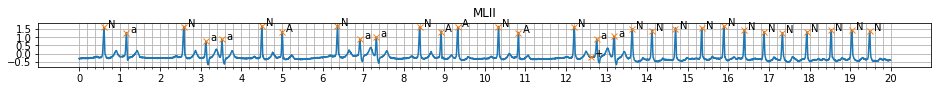

In [12]:
t0 = ( 5*60 +  0) * record.fs  # Normal sinus rhythm
t0 = (10*60 + 16) * record.fs  # Premature ventricular contraction
t0 = (12*60 + 20) * record.fs  # Atrial premature beat, Aberrated atrial premature beat
t0 = (18*60 + 45) * record.fs  # Aberrated atrial premature beat
t0 = (18*60 + 50) * record.fs  # onset of atrial fibrillation
#t0 = (21*60 + 26) * record.fs  # end of atrial fibrillation
#t0 = (22*60 + 13) * record.fs  # some AF between normal sinus rhythm?
#t0 = (25*60 + 18) * record.fs  # onset of Atrial flutter?
#t0 = (27*60 + 55) * record.fs  # AF?
#t0 = (29*60 + 35) * record.fs  # AF?

dt = 20  # in seconds

channel = 0

fig, ax = plt.subplots()
t = np.arange(0, dt, 1/record.fs)
sig = record.p_signal[t0:t0+dt*record.fs, channel]
ax.plot(t, sig)

annotation_mask = (annotation.sample >= t0) & (annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = symbols[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

In [13]:
# preprocessing
cuts = annotation.sample[
    (symbols == 'A') | (symbols == 'a') | (symbols == 'F') | (symbols == 'N') | (symbols == 'V')
]
periods = (cuts[1:] - cuts[:-1]) / record.fs
max_data_len = max(cuts[1:] - cuts[:-1])
data = np.array([
    np.interp(
        np.linspace(0, 1, max_data_len),  # resample so we have the same number of samples per curve
        np.linspace(0, 1, cuts[i+1]-cuts[i]), 
        record.p_signal[cuts[i]:cuts[i+1], 0]
    )
    for i in range(len(cuts)-1)
])
data = data - data.mean(axis=1)[:, np.newaxis]  # vertical align

In [14]:
# alternative way to cut the series
p_r_interval = 0.3
r_s_interval = 0.4


r_wave_positions = annotation.sample[
    (symbols == 'A') | (symbols == 'a') | (symbols == 'F') | (symbols == 'N') | (symbols == 'V')
]
r_wave_positions = r_wave_positions[
    (r_wave_positions - int(p_r_interval * record.fs) >= 0) 
    & (r_wave_positions + int(r_s_interval * record.fs) < record.p_signal.shape[0]) 
]

periods = (r_wave_positions[1:] - r_wave_positions[:-1]) / record.fs
periods = np.append(periods, [periods[-1]])  # the make the length equal to nr of r waves

data = np.array([
    record.p_signal[
        pos - int(p_r_interval * record.fs):pos + int(r_s_interval * record.fs)
        , 0
    ]
    for pos in r_wave_positions
])
data = data - data.mean(axis=1)[:, np.newaxis]  # vertical align

In [15]:
# make period length part of the modelled data
data_p = np.concatenate((data, periods[:,np.newaxis]), axis=1)

In [16]:
# PCA
emission_dim_reduced = 10
pca = sklearn.decomposition.PCA(n_components=emission_dim_reduced)
data_pca = pca.fit_transform(data_p)

def inverse_pca(curve):
    return pca.mean_ + np.dot(curve, pca.components_)

In [17]:
# whitening
data_white = (data_pca / np.sqrt(data_pca.var(axis=0)))

def inverse_white(curve):
    return inverse_pca(curve * np.sqrt(data_pca.var(axis=0)))

# Fit

In [18]:
nr_states = 5
cmap = plt.cm.get_cmap('brg', nr_states)

## kmeans

In [19]:
kmeans = KMeans(nr_states, emission_dim_reduced)
kmeans.fit(data_white)
states = kmeans.predict(data_white)

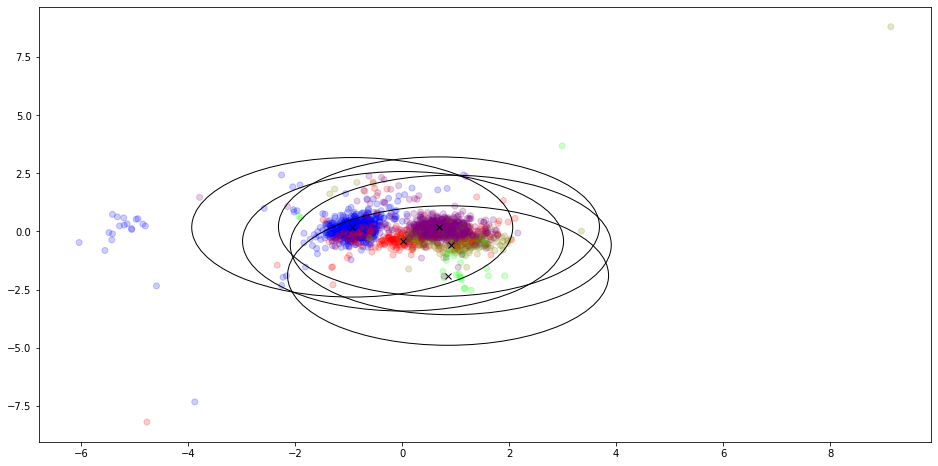

In [20]:
dims = 0, 1
dim0, dim1 = dims
fig, ax = plt.subplots()

plt.scatter(data_pca[:, dim0], data_pca[:, dim1], alpha=0.2, c=states, cmap=cmap)
for s in range(nr_states):
    confidence_ellipse(kmeans.mu[s], np.eye(data.shape[0]), dims, ax, n_std=3, edgecolor='black')
    ax.plot(kmeans.mu[s][dim0], kmeans.mu[s][dim1], 'x', c='black')

In [ ]:
t = np.linspace(0, 1, data.shape[1])
fig, axs = plt.subplots(nr_states)
for s in range(nr_states):
    axs[s].plot(
        np.linspace(0, periods[states == s], data.shape[1]), 
        data[states == s].transpose(), color=cmap(s), alpha=0.01
    )
    axs[s].plot(
        np.linspace(0, inverse_white(kmeans.mu[s])[-1], data.shape[1]), 
        inverse_white(kmeans.mu[s])[:-1], color='black'
    )


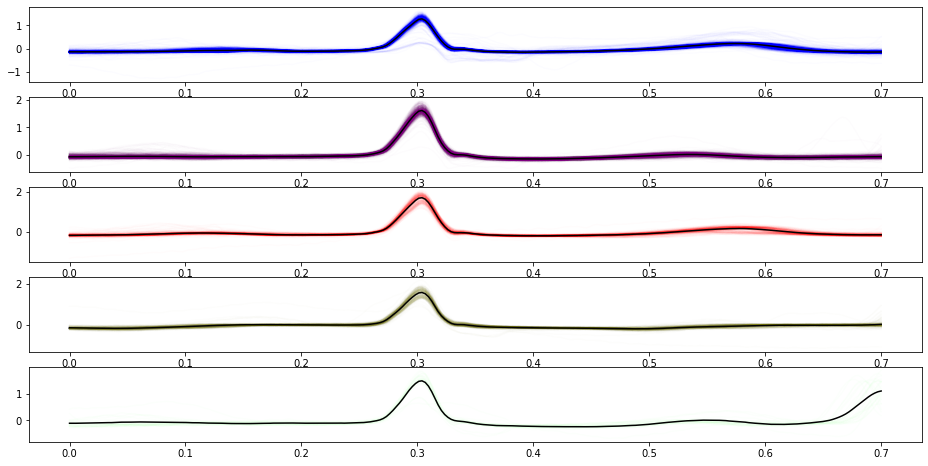

In [22]:
# plot in case preprocessed waves are centered around R
t = np.linspace(0, 1, data.shape[1])
fig, axs = plt.subplots(nr_states)
for s in range(nr_states):
    axs[s].plot(
        np.linspace(0, r_s_interval + p_r_interval, data.shape[1]), 
        data[states == s].transpose(), color=cmap(s), alpha=0.01
    )
    axs[s].plot(
        np.linspace(0, r_s_interval + p_r_interval, data.shape[1]), 
        inverse_white(kmeans.mu[s])[:-1], color='black'
    )

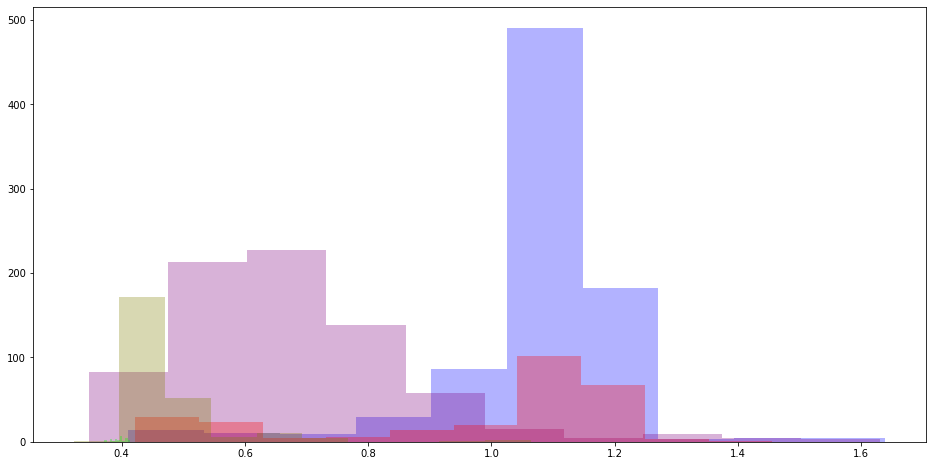

In [23]:
for s in range(nr_states):
    plt.hist(periods[states == s], color=cmap(s), alpha=0.3)

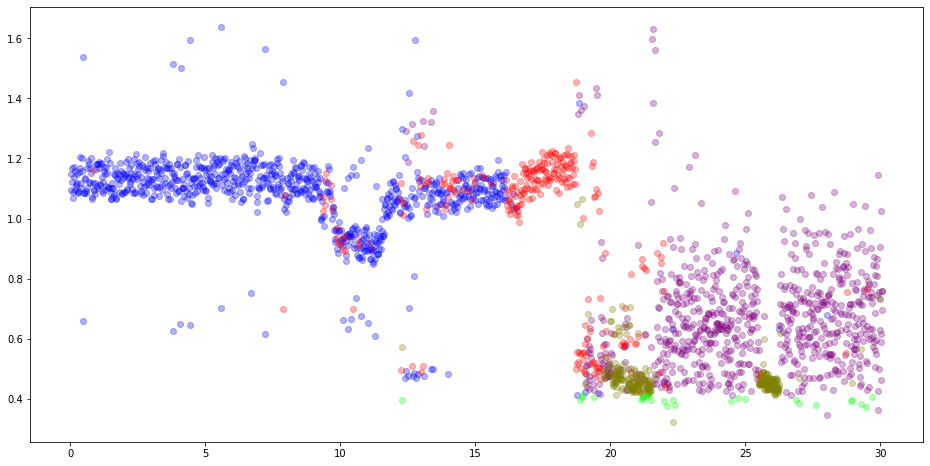

In [24]:
for s in range(nr_states):
    plt.plot(
        cuts[:-1][states == s] / record.fs / 60, 
        periods[states == s], 
        'o', color=cmap(s), alpha=0.3
    )

## hmm

/tmp/ipykernel_67062/3494935137.py:10: RuntimeWarning: divide by zero encountered in log
  np.log(c, out=c)


Negative log likelihood: 18097.503861354016


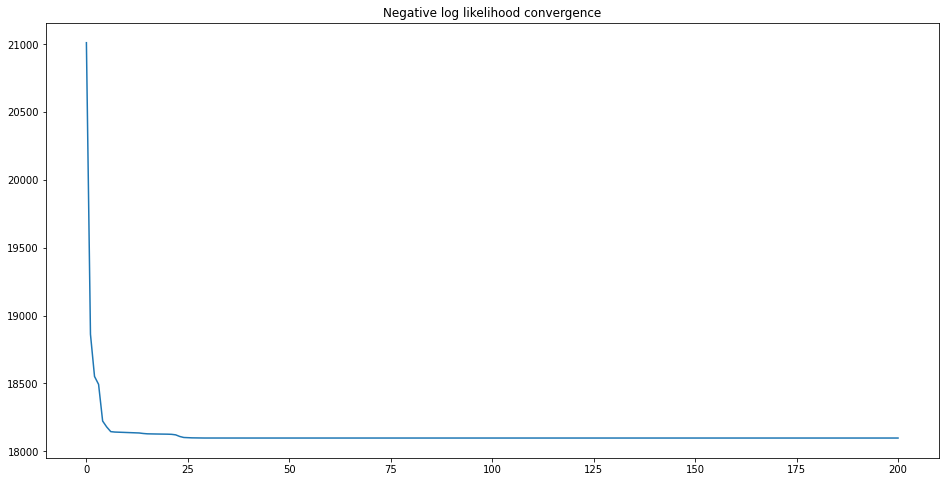

In [25]:
hmm = HMM(nr_states, emission_dim_reduced)
nlls = hmm.fit(data_white)
plt.plot(nlls)
plt.title('Negative log likelihood convergence')
states = hmm.predict(data_white)
print('Negative log likelihood:', nlls[-1])

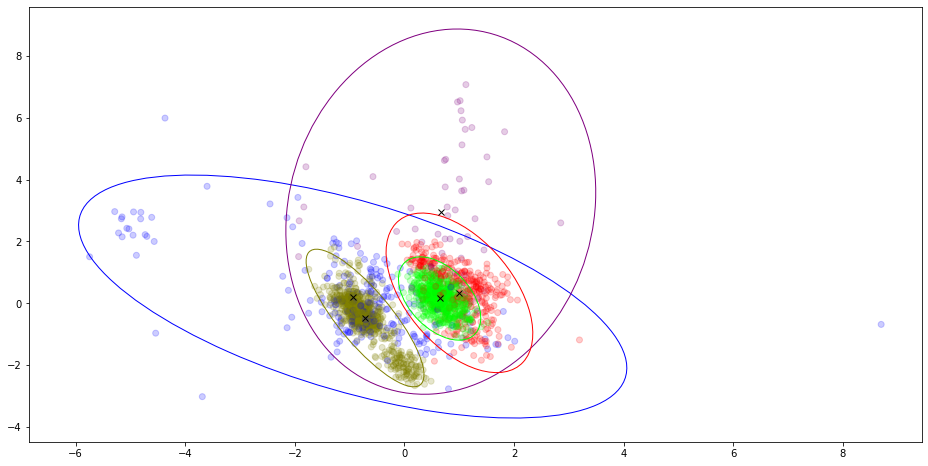

In [43]:
dims = 0, 2
dim0, dim1 = dims
fig, ax = plt.subplots()

plt.scatter(data_white[:, dim0], data_white[:, dim1], alpha=0.2, c=states, cmap=cmap)
for s in range(nr_states):
    confidence_ellipse(hmm.mu[s], hmm.cov[s], dims, ax, n_std=3, edgecolor=cmap(s))
    ax.plot(hmm.mu[s][dim0], hmm.mu[s][dim1], 'x', c='black')

In [ ]:
t = np.linspace(0, 1, data.shape[1])
fig, axs = plt.subplots(nr_states)
for s in range(nr_states):
    axs[s].plot(
        np.linspace(0, periods[states == s], data.shape[1]), 
        data[states == s].transpose(), color=cmap(s), alpha=0.01
    )
    axs[s].plot(
        np.linspace(0, inverse_white(hmm.mu[s])[-1], data.shape[1]), 
        inverse_white(hmm.mu[s])[:-1], color='black'
    )

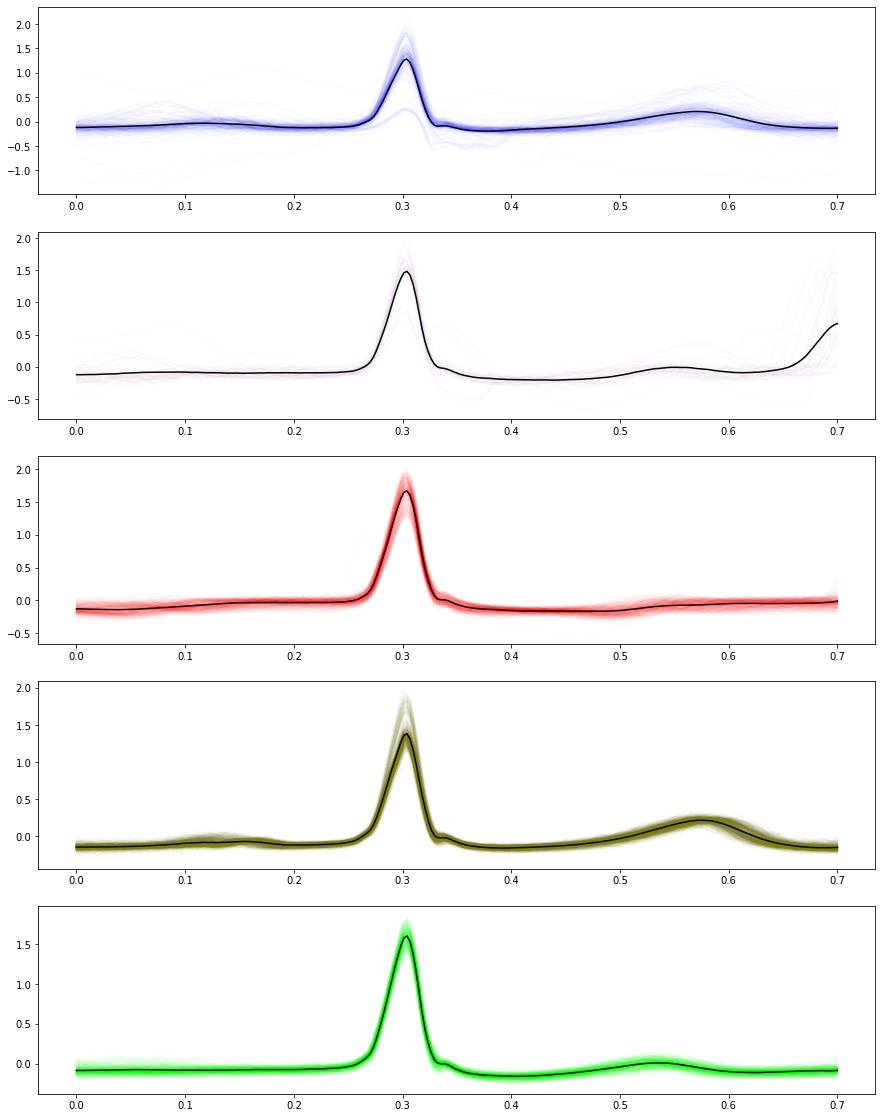

In [44]:
# plot in case preprocessed waves are centered around R
t = np.linspace(0, 1, data.shape[1])
fig, axs = plt.subplots(nr_states)
for s in range(nr_states):
    axs[s].plot(
        np.linspace(0, r_s_interval + p_r_interval, data.shape[1]), 
        data[states == s].transpose(), color=cmap(s), alpha=0.01
    )
    axs[s].plot(
        np.linspace(0, r_s_interval + p_r_interval, data.shape[1]), 
        inverse_white(hmm.mu[s])[:-1], color='black'
    )

fig.set_size_inches(15, 20)

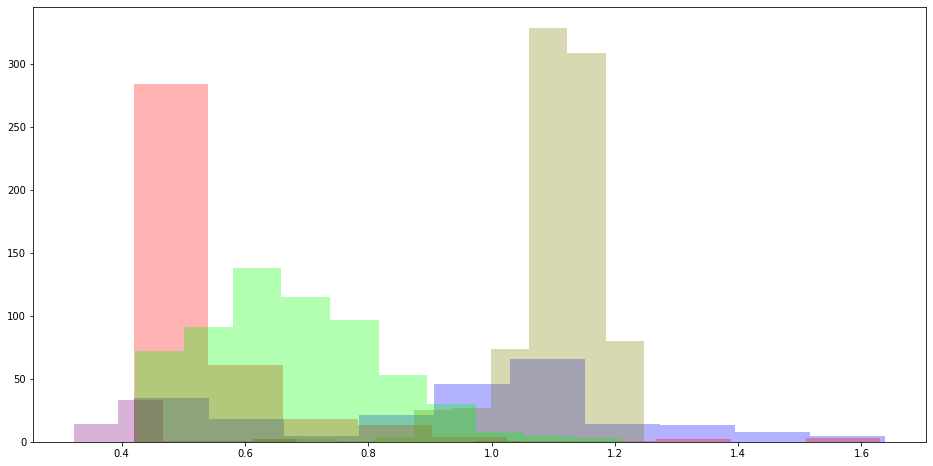

In [45]:
for s in range(nr_states):
    plt.hist(periods[states == s], color=cmap(s), alpha=0.3)

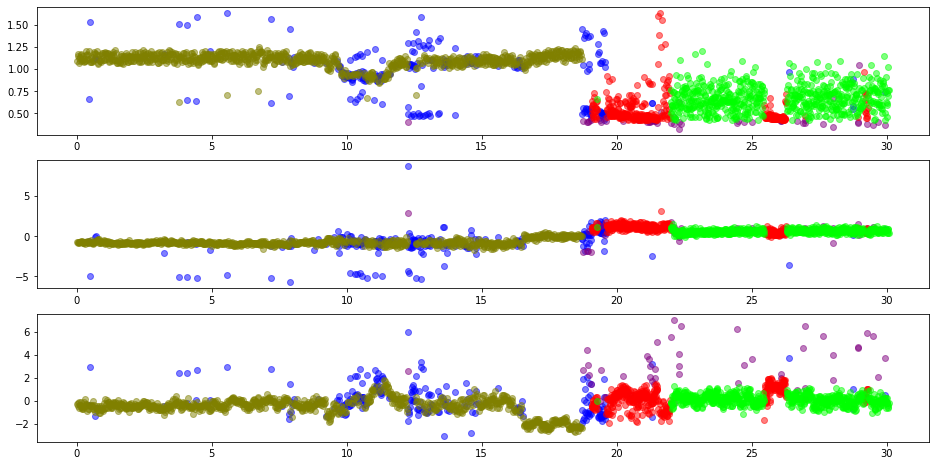

In [46]:
fig, axs = plt.subplots(3)

for s in range(nr_states):
    axs[0].plot(
        cuts[:-1][states == s] / record.fs / 60, 
        periods[states == s], 
        'o', color=cmap(s), alpha=0.5
    )
    axs[1].plot(
        cuts[:-1][states == s] / record.fs / 60, 
        data_white[states == s][:, 0], 
        'o', color=cmap(s), alpha=0.5
    )
    axs[2].plot(
        cuts[:-1][states == s] / record.fs / 60, 
        data_white[states == s][:, 2], 
        'o', color=cmap(s), alpha=0.5
    )

In [51]:
t0 = ( 5*60 +  0) * record.fs  # Normal sinus rhythm
t0 = (10*60 + 16) * record.fs  # Premature ventricular contraction
t0 = (12*60 + 20) * record.fs  # Atrial premature beat, Aberrated atrial premature beat
t0 = (16*60 + 22) * record.fs  # No idea what it sees there
#t0 = (18*60 + 45) * record.fs  # Aberrated atrial premature beat
t0 = (18*60 + 50) * record.fs  # onset of atrial fibrillation
#t0 = (23*60 + 0) * record.fs
#t0 = (19*60 + 40) * record.fs
#t0 = (21*60 + 26) * record.fs  # end of atrial fibrillation
#t0 = (22*60 + 13) * record.fs  # some AF between normal sinus rhythm?
#t0 = (25*60 + 18) * record.fs  # onset of Atrial flutter?
#t0 = (27*60 + 55) * record.fs  # AF?
#t0 = (29*60 + 35) * record.fs  # AF?

dt = 25  # in seconds

channel = 0

fig, ax = plt.subplots()

for i in np.where((cuts >= t0) & (cuts <= t0 + dt * record.fs))[0]:
    t = np.arange(cuts[i]-t0, cuts[i+1]-t0) / record.fs
    sig = record.p_signal[cuts[i]:cuts[i + 1], channel]
    ax.plot(t, sig, color=cmap(states[i]))


annotation_mask = (annotation.sample >= t0) & (annotation.sample < t0+dt*record.fs)
annotation_sub = annotation.sample[annotation_mask]
symbols_sub = symbols[annotation_mask]
annotation_t = (annotation_sub - t0) / record.fs
ax.plot(annotation_t, record.p_signal[annotation_sub, channel], 'x')
for i, symbol in enumerate(symbols_sub):
    ax.annotate(symbol, (annotation_t[i]+0.1, record.p_signal[annotation_sub[i], channel]))

plt.title(record.sig_name[channel])
ax.set_xticks(np.arange(0, dt+0.1, 1))
ax.set_xticks(np.arange(0, dt+0.1, 0.2), minor=True)
ax.set_yticks([])
ax.set_yticks(np.arange(np.ceil(min(sig))-0.5, max(sig), 0.5))
ax.grid(which='both')
ax.set_box_aspect((max(sig)-min(sig))/dt * 0.2/0.5)
pass

fig.tight_layout()
fig.set_size_inches(30, 2)
#fig.savefig('temp.png', dpi=150)

In [ ]:
#%matplotlib inline
%matplotlib qt5